### 1. Запустить код

In [1]:
!python rf.py -tr spam.train.txt -te spam.test.txt

Figure(800x800)
             precision    recall  f1-score   support

        0.0    0.61507   0.87949   0.72389      2033
        1.0    0.96573   0.86053   0.91010      8023

avg / total    0.89484   0.86436   0.87245     10056
final score    0.79040   0.87001   0.81699     10056



### 2. Сравнить RF c другими известными алгоритмами классификации

In [2]:
TRAIN_PATH = 'spam.train.txt'
TEST_PATH = 'spam.test.txt'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from rf import classification_report, visualize_data
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

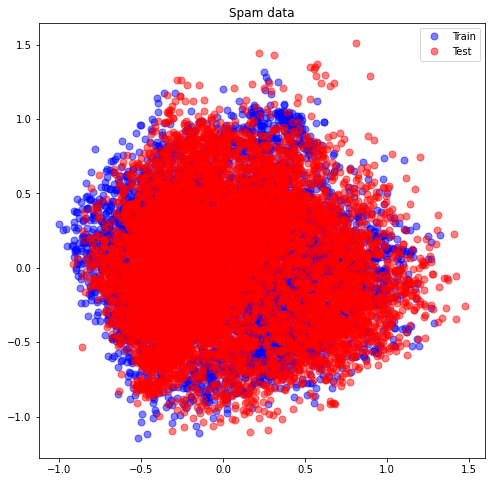

In [4]:
train_data = np.loadtxt(TRAIN_PATH)
test_data  = np.loadtxt(TEST_PATH)

total_data = np.concatenate(([train_data, test_data]), axis=0)

visualize_data(total_data[0::, 1::], len(train_data[:,0]), len(test_data[:,0]))

In [5]:
DEFAULT_TREES = 10
DEFAULT_FEATURE_PERCENT = 0.9

number_of_features = len(train_data[0, :])-1
use_features_in_tree = (int)(DEFAULT_FEATURE_PERCENT * number_of_features)

headers = ["precision", "recall", "f1-score"]
results = {}

classifiers = [
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(),
    SVC(),
    MLPClassifier(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = DEFAULT_TREES, max_features=use_features_in_tree)
]

for classifier in tqdm(classifiers):
    clf = classifier.fit(train_data[0::, 1::], train_data[0::, 0])
    prediction = classifier.predict(test_data[0::, 1::])
    report = classification_report(test_data[0::, 0], prediction, only_final=True)
    
    results[classifier.__class__.__name__] = {header:value for header, value in zip(headers, report)}

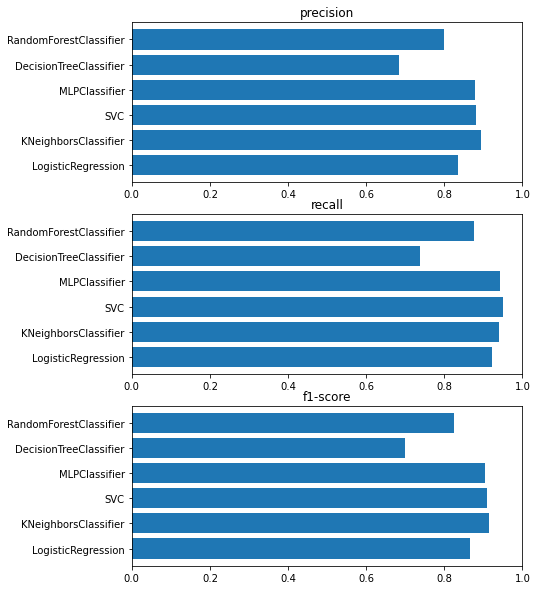

In [6]:
plt.figure(figsize=(7, 10))

for i, header in enumerate(headers):
    plt.subplot(len(headers), 1, i+1)
    plt.title(header)
    
    plt.barh(list(results.keys()),
             [results[k][header] for k in results])
    
    plt.xlim(0, 1)


Видим, что более простыае модели работают лучше — знак того, что RF оверфиттится (слишком большое `max_features`)

### 3. Написать функцию, подбирающую параметры числа деревьев и процента признаков в деревьях. Построить график.

In [7]:
def find_params(classifier, n_trees_options, feature_percent_options, optimized_metric='f1-score'):
    results = []
    
    for n_trees in tqdm(n_trees_options):
        for feature_percent in tqdm(feature_percent_options, leave=False):            
            use_features_in_tree = (int)(feature_percent * number_of_features)
            
            clf = classifier(n_estimators = n_trees, max_features=use_features_in_tree)
            clf = clf.fit(train_data[0::, 1::], train_data[0::, 0])
            
            prediction = clf.predict(test_data[0::, 1::])
            report = classification_report(test_data[0::, 0], prediction, only_final=True)
            
            result = {header:value for header, value in zip(headers, report)}
            result['feature_percent'] = feature_percent
            result['n_trees'] = n_trees
            results.append(result)
            
    results = pd.DataFrame(results)
    
    return results, dict(results.iloc[results[optimized_metric].argmax()][['feature_percent', 'n_trees']])

In [8]:
search_results, best_params = find_params(RandomForestClassifier, [5, 10, 50, 100], 
                             np.linspace(0.1, 1, 10))

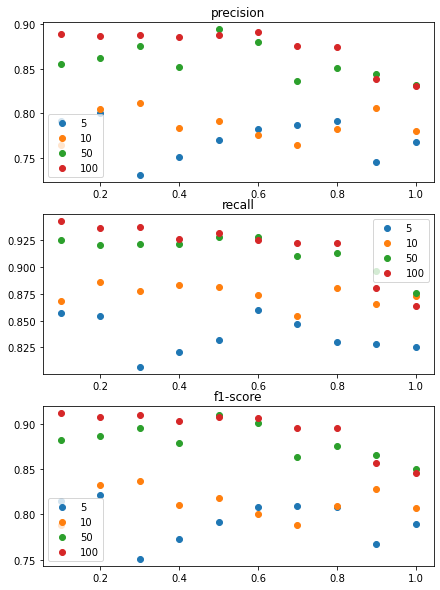

In [11]:
plt.figure(figsize=(7, 10))

for i, header in enumerate(headers):
    plt.subplot(len(headers), 1, i+1)
    plt.title(header)
    
    for n_trees in [5, 10, 50, 100]:
        plt.scatter(search_results[search_results['n_trees']==n_trees]['feature_percent'],
                    search_results[search_results['n_trees']==n_trees][header], label=n_trees)
    plt.legend()

In [12]:
best_params

{'feature_percent': 0.1, 'n_trees': 100.0}

### 4. Ответить на вопрос: Почему качество классификации для класса spam выше, чем для класса notspam?

Критерий gini, используемый при построении отдельного дерева симметричен -> вес ошибки для каждого класса одинаков. Но количество точек для двух классов разное, в итоге в целом больший приоритет будет отдаваться мажоритарному классу. В этом случае это класс spam.